# <a href="https://thetahat.ru/courses/bm-2024-aut"> Статистика ФБМФ </a>

## Задача 1

### Звериный бутстреп

Скачайте архив `animals.zip`, разархивируйте его и положите в ту же папку, где лежит ноутбук. Если у вас не установлена библиотека `skimage` это можно сделать раскомментировав следующую ячейку.

In [1]:
# Установка библиотек
! pip install scikit-image
! pip install tqdm

Готово! Теперь можно начинать работу над заданием.

In [2]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import resize
from tqdm import tqdm

Изображения в numpy хранятся в виде трехмерного массива согласно RGB модели: две оси соответствуют положению пикселя на картинке, а третья &mdash; каналу. То есть для каждого пикселя мы имеем набор из трех чисел, который отвечает за интенсивность красного, зеленого и синего цветов.

<img src="https://images.prismic.io/turing/65a53efc7a5e8b1120d5891a_RGB_color_channel_6b6d1cf03e.webp?auto=format,compress" width=350 height=300>

В данном задании имеется выборка, состоящая из картинок пяти зверюшек. Нужно оценить дисперсию среднего значения отдельно для каждого пикселя картинки и каждого цветового канала. 

Загружаем картинки зверюшек и приводим их к размеру 500 на 500. Каждая картинка представляется в виде трехмерной матрицы размера (500, 500, 3) чисел от 0 до 1. Таким образом у нас есть выборка размера 5 из $(500\cdot500\cdot3)$-мерного пространства.

In [4]:
n = 5
images = [plt.imread('animals/animal_{}.jpg'.format(i + 1)) for i in range (n)]
images = [resize(images[i], (500, 500, 3)) for i in range (n)]

images[0].shape

(500, 500, 3)

Визуализируем все изображения при помощи функции `plt.imshow()`. Вызов функций `plt.xticks([]), plt.yticks([])` убирает подписи к координатным осям, `plt.tight_layout()` обрезает пустые поля графиков, а `facecolor=(0,0,0,0)` делает фон графика прозрачным при сохранении (четыре числа &mdash; красный, зеленый, синий, прозрачность).

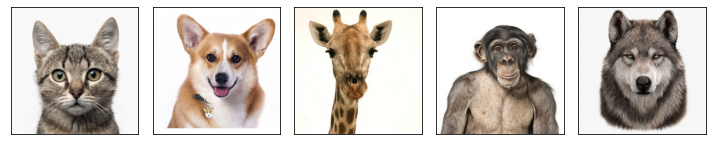

In [5]:
plt.figure(figsize=(10, 3))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.savefig('zoo.png', facecolor=(0,0,0,0))
plt.show()

Для визуализации в дальнейшем также загрузим изображение стрелки.

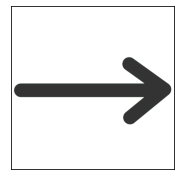

In [7]:
arrow = plt.imread('animals/arrow.png')

plt.figure(figsize=(3, 3))
plt.imshow(arrow)
plt.xticks([])
plt.yticks([]);

Напишем функцию, реализующую бутстреп. Вам необходимо заполнить пропуски, где они есть. Помните, что картинки &mdash; это просто трехмерные массивы, а значит на них определены все арифметические операции.

In [8]:
def zoo_bootstrap(images, B=6, draw=False):
    '''
    Генерирует B бутстрепных выборок изображений 
    и возвращает среднее по каждой из них. 
    Если указан параметр draw, то рисует процесс на графике.
    '''
    # размер выборки
    n = len(images)
    # средние по бутстрепным выборкам
    bootstrap_means = []  
    
    if draw:
        plt.figure(figsize=(11.5, 9.5))

    for b in tqdm(range(B)):
        # сумма элементов бутстрепной выборки
        sum_bsample = 0

        for i in range(5):
            # генерируем элемент бутстрепной выборки
            ind = np.random.randint(0, n)

            # добавляем его к сумме по этой выборке
            sum_bsample += images[ind]

            # визуализация элемента бутстрепной выборки
            if draw:
                plt.subplot(B, n + 2, b * (n + 2) + i + 1)

                plt.imshow(images[ind])

                plt.xticks([])
                plt.yticks([])
                if i == 0:
                    plt.ylabel('$X^*_{}$:       '.format(b+1), 
                               rotation=0, fontsize=26)
        
        # добавляем среднее по бутстрепной выборке
        current_mean = sum_bsample/5
        bootstrap_means.append(current_mean)

        if draw:
            # стрелка
            plt.subplot(B, n+2, b*(n+2)+i+2)
            plt.imshow(arrow)
            plt.axis('off'), plt.xticks([]), plt.yticks([])
            
            # среднее по бутстрепной выборке
            plt.subplot(B, n+2, b*(n+2)+i+3)
            plt.imshow(bootstrap_means[-1])
            plt.xticks([]), plt.yticks([])
            
    if draw:
        plt.tight_layout()
        plt.savefig('animals/zoo_bootstrap.png', facecolor=(0,0,0,0))
        plt.show()
    
    return bootstrap_means

Посмотрим, что получается на выборках размера 6. Ниже будет выведена схема бутстрепа. По строкам изображены бутстрепные выборки (разумеется, размера 5). В последнем столбце по каждой бутстрепной выборке посчитано среднее всех пикселей.

100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


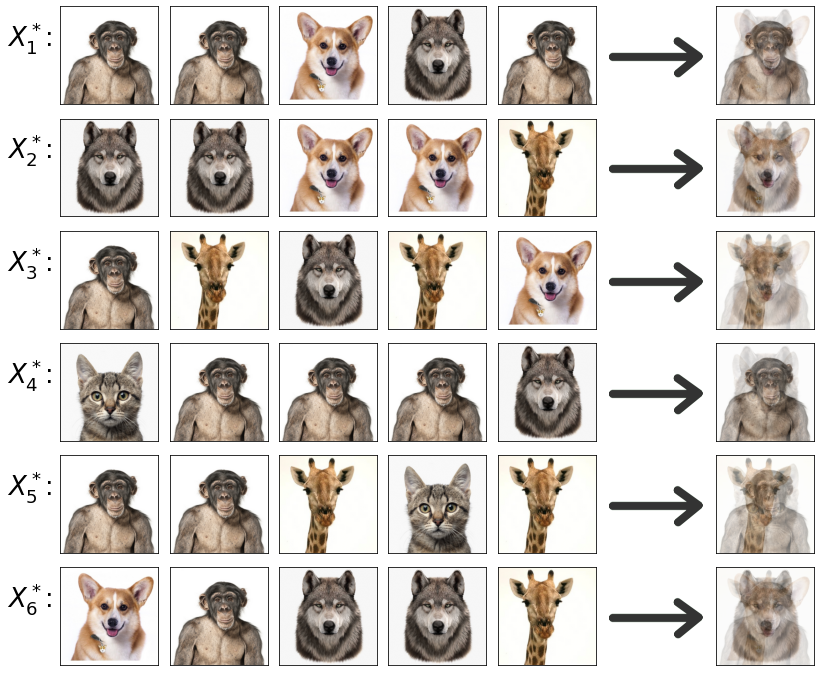

In [9]:
bootstrap_means = zoo_bootstrap(images, draw=True)

По бутстрепной выборке средних (правый столбец выше) можем посчитать выборочную дисперсию для каждого пикселя. Поскольку цвета изображения должны быть от 0 до 1, для визуализации нормируем все дисперсии на максимальное значение по всем пикселям и цветовым каналам. Очевидно, что минимальное значение дисперсий равно нулю --- в крайних пикселях всегда белый фон.

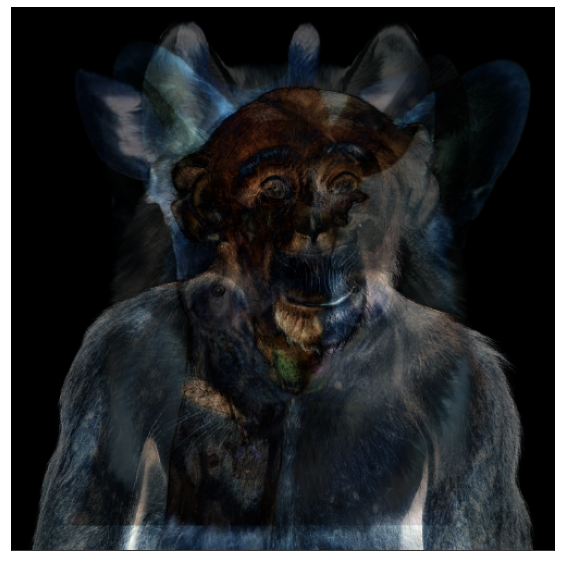

In [11]:
bootstrap_var = np.var(bootstrap_means, axis=0)
bvar_normed = bootstrap_var / bootstrap_var.max(axis=(0, 1)).reshape((1, 1, 3))

plt.figure(figsize=(10, 10))
plt.imshow(bvar_normed)
plt.xticks([]), plt.yticks([]);
plt.savefig('animals/zoo_bootstrap_var.png', facecolor=(0,0,0,0))
plt.show()


Посмотрим на результат при большем количестве бутстрепных выборок

100%|██████████| 300/300 [00:07<00:00, 37.93it/s]


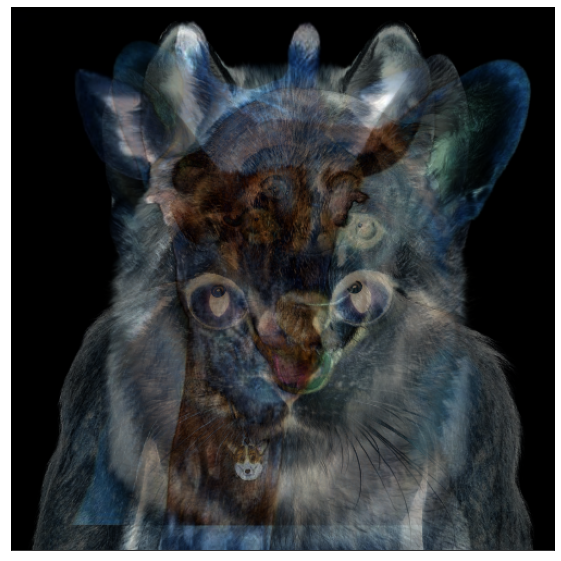

In [12]:
bootstrap_means = zoo_bootstrap(images, B=300)
bootstrap_var = np.var(bootstrap_means, axis=0)
bvar_normed = bootstrap_var / bootstrap_var.max(axis=(0, 1)).reshape((1, 1, 3))

plt.figure(figsize=(10, 10))
plt.imshow(bvar_normed)
plt.xticks([]), plt.yticks([]);
plt.savefig('animals/zoo_bootstrap_var.png', facecolor=(0,0,0,0))
plt.show()

**Вывод:**

Смогли с помощью бутстрепного анализа оценить дисперсию пикселей, даже не зная распределения для каждого пикселя. Картинка с увеличением бутрепной выборки стала более яркой - каждое животное на ней видно более чётко.

## Задача 2

### Bias-variance

Сравним между собой несколько оценок в среднеквадратичном подходе и рассмотрим, что представляет из себя bias-variance tradeoff. Рассмотрим $X_1,...,X_n$ &mdash; выборку из распределения $U[0, \theta]$. Будем сравнивать между собой оценки: $2\overline{X}$, $X_(n)$, $\frac{n + 1}{n}X_(n)$

Для сравнения оценок между собой можно использовать различные функции риска. В данном случае мы рассмотрим MSE (Mean Squared Error), которая распадается в сумму слагаемых, отвечающих двум важным свойствам оценок: смещение (насколько оценка в среднем отличается от истины) и разброс (насколько разные значения дает оценка). 

- $bias^2 = (E\hat{\theta} - \theta)^2$ 

- $variance = D\hat{\theta} = E\hat{\theta}^2 - (E\hat{\theta})^2$

- $MSE = E(\theta - \hat{\theta})^2 = bias^2 + variance$

Для удобства вычислений приведем первые моменты случайных величин.
- $EX_1 = \frac{\theta}{2}, EX_1^2 = \frac{\theta^2}{12}$;

- $EX_{(n)} = \frac{n}{n + 1}\theta, EX_{(n)}^2 = \frac{n}{n + 2}\theta^2$.

Выпишите формулы $bias^2$ и variance для каждой из трех оценок:

$2\overline{X}: bias^2 = 0, variance =\frac{\theta^2}{3n} $

$X_n: bias^2 = \frac{\theta^2}{(n + 1)^2}$, variance = $\frac{ n\theta^2}{(n+2)(n+1)^2}$

$\frac{n + 1}{n}X_n: bias^2 = 0$, variance = $(\frac{n+1}{n})^2*\frac{ n\theta^2}{(n+2)(n+1)^2}$

Как мы можем видеть, все слагаемые зависят от параметра $\theta$ квадратично, поэтому нам достаточно рассмотреть зависимость от размера выборки при фиксированном $\theta$.

Напишите функции, которые для массива размеров выборок и параметра $\theta$ будут возвращать два `np.array`: первый - массив квадратов смещений ($bias^2$), второй - массив дисперсий ($variance$), посчитанные по формулам выше.

In [32]:
def mean_estimator(n_range, theta=1):
    bias = np.array (n_range*0)
    variance = np.array((theta**2)/(3*n_range))

    return bias, variance

def max_estimator(n_range, theta=1):
    bias = np.array((theta**2)/((n_range+1)**2))
    variance = n_range*(theta**2)/((n_range+2)*(n_range+1)**2)

    return bias, variance

def unbiased_max_estimator(n_range, theta=1):
    bias = np.array (n_range*0)
    variance = (((n_range+1)/n_range)**2)*(n_range*(theta**2)/((n_range+2)*(n_range+1)**2))

    return bias, variance

In [33]:
def draw_bias_variance(n_range, estimator, label, color, axs):
    bias, variance = estimator(n_range)

    axs[0].plot(n_range, bias, color=color, label=label)
    axs[1].plot(n_range, variance, color=color, label=label)
    axs[2].plot(n_range, bias + variance, color=color, label=label)

    axs[0].set_title("$bias^2$")
    axs[1].set_title("$variance$")
    axs[2].set_title("$MSE$")

    for i, ax in enumerate(axs):
        ax.set_xlabel("Размер выборки")
        ax.set_ylabel("Значение метрики" if i == 0 else "")
        ax.legend(loc='center right')

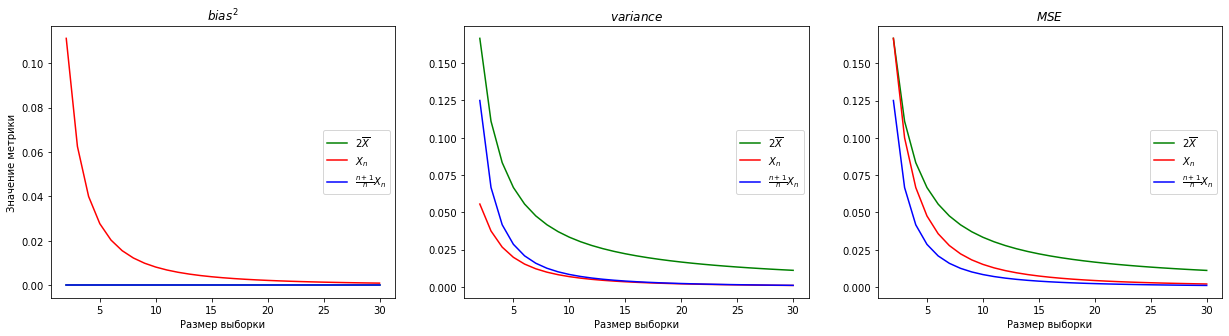

In [34]:
n_range = np.arange(2, 31)

estimators = [("$2\overline{X}$", mean_estimator, "green"),
              ("$X_n$", max_estimator, "red"),
              ("$\\frac{n + 1}{n}X_n$", unbiased_max_estimator, "blue")]

fig, axs = plt.subplots(ncols=3, figsize=(21, 5))

for name, estimator, color in estimators:
    draw_bias_variance(n_range, estimator, label=name, color=color, axs=axs)

Сделайте выводы из полученного графика. Как оценки отличаются между собой? Можно ли сравнить оценки в среднеквадратичном подходе?

**Вывод:**

Оценка $X_{n}$ - смещённая в отличие от остальных, но зато у неё самая низкая дисперсия. Мы можем сравнивать оценки по MSE, так как она информацию в среднем о свойствах оценки. И здесь на всём протяжении оценки падают, так что выводы однозначны

Теперь рассмотрим те же самые свойства оценок, но изобразим их на графике зависимости значения оценок от размера выборки.

Допишите функции ниже, чтобы они давали кумулятивные оценки.

In [49]:
def cumulitive_mean_estimator(X):
    return 2* np.cumsum(n_range)/(np.arange(0,len(n_range)+1))

def cumulitive_max_estimator(X):
    return n_range

def cumulitive_unbiased_max_estimator(X):
    return (((np.arange(0,len(n_range)+1)+1)/(np.arange(0,len(n_range)+1)))*n_range)

In [68]:
def cumulitive_mean_estimator(X):
    return 2* np.cumsum(X, axis = 1)/(np.arange(1,len(X[0])+1))

def cumulitive_max_estimator(X):
    return np.maximum.accumulate(X, axis = 1)

def cumulitive_unbiased_max_estimator(X):
    return ((np.arange(1,len(X[0])+1)+1)/(np.arange(1,len(X[0])+1)))*np.maximum.accumulate(X, axis = 1)

In [69]:
def draw_estimations(estimations, label, color, alpha=0.1):
    n_range = np.arange(estimations.shape[-1]) + 1

    for i in range(len(estimations)):
        plt.plot(n_range, estimations[i], 
                alpha=alpha, color=color)
        
    plt.plot(n_range, np.mean(estimations, axis=0), 
             label=label, color=color, linewidth=3)

    plt.ylim(0.25, 1.5)
    plt.xlabel("Размер выборки")
    plt.ylabel("Значение оценки")
    plt.title("Зависимость оценки параметра от размера выборки")
    plt.legend()

In [70]:
sample_size = 20
sample_count = 30
X = sps.uniform.rvs(size=(sample_count, sample_size))

n_range = np.arange(sample_size) + 1

cumulitive_estimations = [(" Мат. ож. $2\overline{X}$", cumulitive_mean_estimator(X), "green"),
                        ("$Мат. ож. X_n$", cumulitive_max_estimator(X), "red"),
                        ("$Мат. ож. \\frac{n + 1}{n}X_n$", cumulitive_unbiased_max_estimator(X), "blue")]

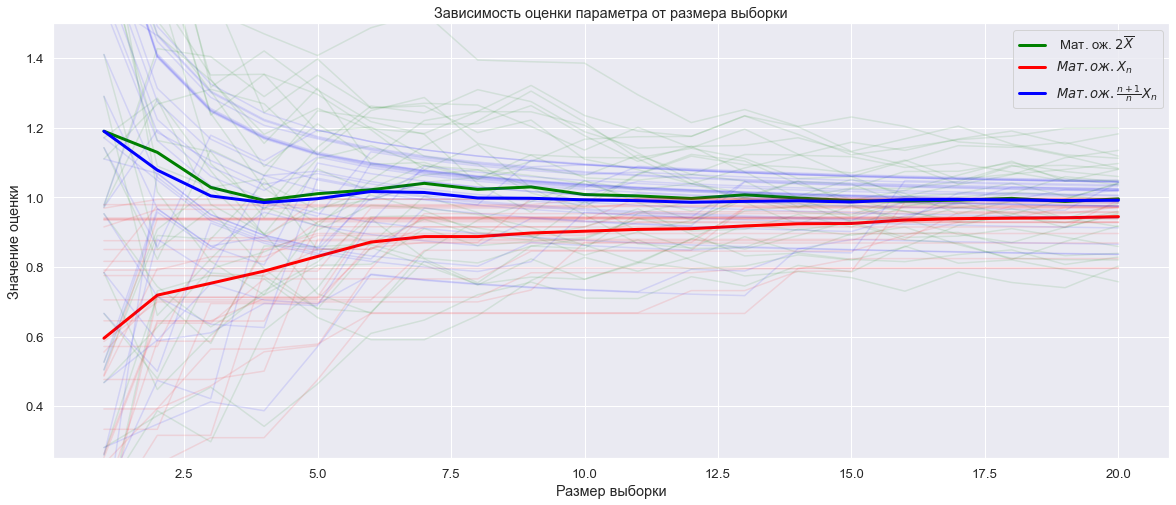

In [71]:
sns.set(font_scale=1.2, palette='Set2')
plt.figure(figsize=(20, 8))

for label, estimations, color in cumulitive_estimations:
    draw_estimations(estimations, label, color)

Сделайте выводы. Согласуются ли результаты с предыдущими? Как проявляются различия в смещенности и разбросе оценок на графике? 

**Выводы:**

Да, результаты согласуются с предыдушим пунктом - видно, что для $X_{n}$ характерен самый маленький разброс (дисперсия), но при этом самое большое отклонение, особенно при маленьких выборках. Для двух оставшихся оценок ситуация обратная.